In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations
from numba import njit

In [2]:
from scipy import array, real, dot, column_stack, row_stack, append
import numpy as np
ra = np.random
la = np.linalg

def PathSPCA(A, k):
    """Compute leading k-sparse principal component for matrix A"""
    M, N = A.shape

    set_N = set(range(N))
    # Loop through variables
    As = (A * A).sum(axis=0)
    vp = As.argmax()
    subset = [vp]
    vars = []
    res = subset
    rhos = [(A[:, vp] * A[:, vp]).sum()]
    Stemp = array([rhos])
    for i in range(1, k):
        lev, v = la.eig(Stemp)
        vars.append(real(lev).max())
        vp = real(lev).argmax()
        x = dot(A[:, subset], v[:, vp])
        x = x / la.norm(x)
        seto = list(set_N - set(subset))
        vals = dot(x.T, A[:, seto])
        vals = vals * vals
        rhos.append(vals.max())
        vpo = seto[vals.argmax()]
        Stemp = column_stack((Stemp, dot(A[:, subset].T, A[:, vpo])))
        vbuf = append(dot(A[:, vpo].T, A[:, subset]),
                      array([(A[:, vpo] * A[:, vpo]).sum()]))
        Stemp = row_stack((Stemp, vbuf))
        subset.append(vpo)
    lev, v = la.eig(Stemp)
    vars.append(real(lev).max())
    return vars, res, rhos

In [3]:
def spca_bourin(A, k_=None):
    k, _ = A.shape
    if k_ is None:
        k_ = k
    l_list = []
    for i in range(1, k_+1):
        l_max = 0.
        for idx in permutations(range(k), i):
            B = A[idx, :][:, idx]
            l_max = max(l_max, np.linalg.norm(B, ord=2))
        l_list.append(l_max)
    return l_list

In [4]:
@njit
def st(x, u):
    return np.sign(x) * np.maximum(np.abs(x) - u, 0.)

In [5]:
@njit
def loss(D, x, z, lbda):
    res = D.dot(z) - x
    return 0.5 * np.sum(res ** 2) + lbda * np.sum(np.abs(z))

In [26]:
@njit
def ista(D, x, lbda, L, max_iter, z):
    k, p = D.shape
    l_list = np.zeros(max_iter)
    for i in range(max_iter):
        l_list[i] = loss(D, x, z, lbda)
        u = st(z - D.T.dot(D.dot(z) - x) / L, lbda / L)
        if u.dot(u) < 1e-12:
            break
        z = u
    return z, l_list

In [139]:
@njit
def ista_s(D, x, lbda, v, max_iter, z):
    k, p = D.shape
    l_list = []
    k_list = []
    success = False
    for i in range(max_iter):
        l_list.append(loss(D, x, z, lbda))
        k = np.sum(z != 0)
        k_list.append(k)
        L = v[k-1]
        u = st(z - D.T.dot(D.dot(z) - x) / L, lbda / L)
        d = z - u
        if d.dot(d) < 1e-12:
            success = True
            break
        z = u
    return z, l_list, success, k_list

In [248]:
@njit
def fista(A, b, l, v, maxit, x):
    t = 1
    z = x.copy()
    l_list = []
    k_list = []
    for _ in range(maxit):
        l_list.append(loss(A, b, x, l))
        xold = x.copy()
        k = np.sum(x != 0)
        k_list.append(k)
        L = v[k - 1]
        z = z + A.T.dot(b - A.dot(z)) / L
        x = st(z, l / L)
        t0 = t
        t = (1. + np.sqrt(1. + 4. * t ** 2)) / 2.
        z = x + ((t0 - 1.) / t) * (x - xold)
    return x, np.array(l_list), np.array(k_list)

[3.38120931719268, 4.1936774008306115, 5.0471480354649625, 5.556745352891595, 5.606072115225226]


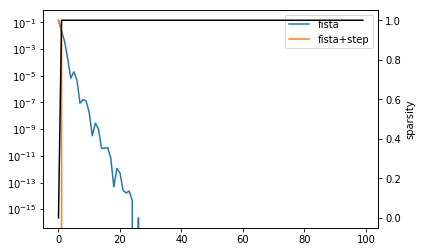

In [326]:
k, p = 2, 5
D = np.random.randn(k, p)
L = np.linalg.norm(D, ord=2) ** 2
x = np.random.randn(k)
z0 = np.zeros(p)
lbda = 0.5 * np.max(np.abs(D.T.dot(x)))
v = spca_bourin(D.T.dot(D), p)
print(v)
fig, ax1 = plt.subplots()

_, l_l, _ = fista(D, x, lbda, L * np.ones(p), 10000, z0)
for v_, label in zip([L * np.ones(p), v], ['fista', 'fista+step']):
    z, l_list, k_list = fista(D, x, lbda, v_, 100, z0)
    ax1.semilogy(l_list - l_l[-1], label=label)
ax2 = ax1.twinx()
ax2.plot(k_list, c='k')
ax2.set_ylabel('sparsity')
ax2.tick_params('y')
ax1.legend()

In [322]:
k_list

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [192]:
p = 5
D = np.random.randn(k, p)
L = np.linalg.norm(D, ord=2) ** 2
x = np.random.randn(k)
z0 = np.zeros(p)
lbda = 0.5 * np.max(np.abs(D.T.dot(x)))
v = spca_bourin(D.T.dot(D), p)

z_star, l_star, s, k_list = ista_s(D, x, lbda, v, max_iter, z=z0.copy())
z_star, l_list = ista(D, x, lbda, L, max_iter, z=z0.copy())
k_list[0] = p

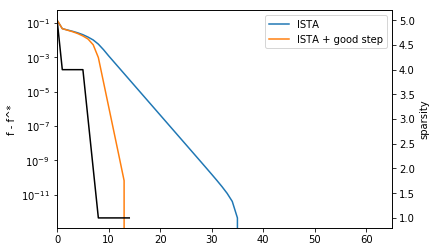

In [193]:
fig, ax1 = plt.subplots()
ax1.plot(l_list - l_star[-1], label='ISTA')
ax1.plot(np.array(l_star) - l_star[-1], label='ISTA + good step')
ax1.set_ylabel('f - f^*')
ax1.tick_params('y')
ax1.set_xlim([0, len(l_star) + 50])
ax1.set_yscale('log')
ax2 = ax1.twinx()
ax2.plot(k_list, c='k')
ax2.set_ylabel('sparsity')
ax2.tick_params('y')
ax1.legend()

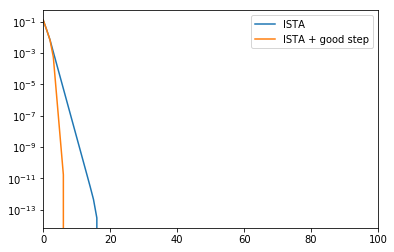

In [154]:
plt.semilogy()
plt.semilogy(np.array(l_star) - l_star[-1], label='ISTA + good step')
plt.xlim(0, 100)
plt.legend()

In [155]:
k_list

[0, 3, 2, 1, 1, 1, 1, 1]

In [92]:
v

[5.845869124745449,
 9.942295251365273,
 12.229187672048585,
 12.386052757091166,
 12.387106194608887]

In [93]:
L

12.38710619460888

In [94]:
z0

array([0., 0., 0., 0., 0.])

In [95]:
l_star

array([0.99866238, 0.96596346, 0.94595165, ..., 0.87116036, 0.87116036,
       0.87116036])

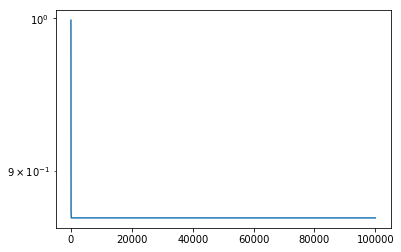

In [96]:
plt.semilogy(l_star)


In [97]:
z_star - st(z_star - D.T.dot(D.dot(z_star) - x) / L, lbda / L)

array([ 2.99729378e-06, -1.70405929e-06,  0.00000000e+00, -1.29354318e-06,
        0.00000000e+00])